# Filtering and Restoring of Mixed and Noise Polluted Audio Samples Using Different Approaches

In [ ]:
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

inp_folder = 'audio'
outp_folder = 'output'

In [ ]:
file_names = ['speech.wav', 'street-noise.wav', 'music.wav', 'white-noise.wav', 'tone_10kHz.wav']

audio_speech, sr_speech = sf.read(os.path.join(inp_folder, file_names[0])) # , always_2d=True
audio_street, sr_street = sf.read(os.path.join(inp_folder, file_names[1]))
audio_music, sr_music = sf.read(os.path.join(inp_folder, file_names[2]))
audio_wnoise, sr_wnoise = sf.read(os.path.join(inp_folder, file_names[3]))
audio_test_tone, sr_test_tone = sf.read(os.path.join(inp_folder, file_names[4]))
print("Array Type is: {}".format(audio_music.dtype))
# Attenuate white noise amplitude 
attenuation_ratio = 1/4
audio_files = [audio_speech, audio_street, audio_music, audio_wnoise * attenuation_ratio, audio_test_tone]
sample_rates = [sr_speech, sr_street, sr_music, sr_wnoise, sr_test_tone]

for name, sr, audio in zip(file_names, sample_rates, audio_files):
    print("File: {}, Sample Rate: {}, Samples: {}, Time: {}sec".format(name, sr, len(audio), len(audio)/sr))

In [ ]:
make_mono = True
# Reduce from stereo to mono
if make_mono:
    for ii, audio in enumerate(audio_files):
        if len(audio.shape) == 2:
            peak_l = max(audio[:, 0])
            peak_r = max(audio[:, 1])
            peak_pre = max(peak_l, peak_r)
            audio_files[ii] = np.sum(audio, axis=1)
            audio_files[ii] /= max(audio_files[ii])
            audio_files[ii] *= peak_pre
            print("Shape File {}: {}".format(ii+1, audio_files[ii].shape))       

In [ ]:
import samplerate

max_sr = max(sample_rates)
converter = 'sinc_best'

for ii, (audio, sr) in enumerate(zip(audio_files, sample_rates)):
    if sr != max_sr:
        ratio = max_sr / sr
        audio_files[ii] = samplerate.resample(audio, ratio, converter)
        print("New Shape: {}".format(audio_files[ii].shape))
        sample_rates[ii] = max_sr
        
for name, audio in zip(file_names, audio_files):
    print("File: {}, Sample Rate: {}, Samples: {}, Time: {}sec".format(name, max_sr, len(audio), len(audio)/sr))

In [ ]:
# Find minimal audio length
audio_length = []
for ii, audio in enumerate(audio_files):
    audio_length.append(len(audio))
max_length = min(audio_length)
print("Minimal number of audio samples: {}".format(max_length))

In [ ]:
# Determine Audio length
# Neede samples are samples = time * sample_rate
time = max_length / sample_rates[audio_length.index(max_length)]

adj_audio_length = []
for sr in sample_rates:
    adj_audio_length.append(int(time * sr))

print("Max audio length is {} s".format(time))
for name, smp_has, smp_should in zip(file_names, audio_length, adj_audio_length):
    print("File {} has {} Samples and must have {}".format(name, smp_has, smp_should))

In [ ]:
# Unify audio file length
for ii, smp in enumerate(adj_audio_length):
    audio_files[ii] = audio_files[ii][:smp]
    print("Shape file {}: {}".format(ii+1, audio_files[ii].shape))

# Time-Domain

Time plot of original audio files $u$ and noise sources $v$.

| Audio | Symbol |
| --- | --- |
| Speech | $u_s$ | 
| Street Noise | $v_{sn}$ |
| Music | $u_m$ |
| White Noise | $v_{wn}$ |

In [ ]:
fig, axs = plt.subplots(len(audio_files), 1, figsize=[18, 10], sharex=False, constrained_layout = True)
audio_names = ['Speech $u_s$', 'Street Noise $v_{sn}$', 'Music $u_m$', 'White Noise $v_{wn}$', 'Tone 10kHz']
colors = ['blue', 'red', 'green', 'black', 'orange']
for ii, (audio, name, sr, color) in enumerate(zip(audio_files, audio_names, sample_rates, colors)):
    x_axis = np.arange(0, len(audio)) / sr
    axs[ii].plot(x_axis, audio, lw=5, color=color)
    axs[ii].set_title(name, fontsize=25)

fig.supylabel('Amplitude', fontsize=20)
fig.supxlabel('Time in Sec', fontsize=20)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Spectrum

Frequencies in original audio files.

In [ ]:
# Fast Fourier Transform
from scipy.fftpack import fft, fftfreq

spectrums = []
fft_x = []
for audio, sample_rate, samples in zip(audio_files, sample_rates, adj_audio_length):
    frequencies = fft(audio)
    T = 1/sample_rate
    x_axis = fftfreq(samples, T)[:samples//2]
    spectrums.append(2.0/samples * np.abs(frequencies[0:samples//2]))
    fft_x.append(x_axis)


In [ ]:
fig, axs = plt.subplots(len(audio_files), 1, figsize=[18, 10], sharex=False, constrained_layout = True)

for ii, (spectrum, x_axis, name, color) in enumerate(zip(spectrums, fft_x, audio_names, colors)):
    axs[ii].plot(x_axis / 1e3, spectrum, lw=5, color=color)
    axs[ii].set_title(name, fontsize=25)

fig.supylabel('Magnitude', fontsize=20)
fig.supxlabel('Frequency in kHz', fontsize=20)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

In [ ]:
# Save Files
names_source_out = ['speech_source.wav', 'street_source.wav', 'music_source.wav', 'white_noise_source.wav', 'tone_10kHz_source.wav']
for name, audio, sr in zip(names_source_out, audio_files, sample_rates):
    sf.write(os.path.join(outp_folder, name), audio, sr)

# Mix Signals

Generate four observations $d$. 

1. Music + White Noise $d_{m+wn}$
1. Street Noise + Music $d_{sn+m}$
1. Street Noise + Music + Speech $d_{sn+m+s}$
1. Speech + White Noise $d_{s+wn}$

In [ ]:
# 1           Music +       White Noise
d_m_wn = audio_files[2] + audio_files[3]
# 2           Street +      Music
d_sn_m = audio_files[1] + audio_files[2]
# 3 :         Street +      Music +             Speech
d_sn_m_s = audio_files[1] + audio_files[2] + audio_files[0]
# 4 :         Speech +      White Noise
d_s_wn = audio_files[0] + audio_files[3]

observations = [d_m_wn, d_sn_m, d_sn_m_s, d_s_wn]


## Add seed for same results

In [ ]:
np.random.seed(10)

# Independent Component Analysis (ICA)

In [ ]:
from sklearn.decomposition import FastICA

### Combine Test Signals

Generating signals for observation #3 and apply to "cocktail party problem".

In [ ]:
# 3 :                   Street +            Music +                 Speech
d_sn_m_s_1 = 0.3 * audio_files[1] + 0.3 * audio_files[2] + 0.4 * audio_files[0]
d_sn_m_s_2 = 0.6 * audio_files[1] + 0.2 * audio_files[2] + 0.2 * audio_files[0]
d_sn_m_s_3 = 0.1 * audio_files[1] + 0.7 * audio_files[2] + 0.2 * audio_files[0]

### Combine and Normalize Data

In [ ]:
true_signal = np.c_[d_sn_m_s_1, d_sn_m_s_2, d_sn_m_s_3]

true_signal /= true_signal.std(axis=0)

### Generate Observation with Mixing Matrix

In [ ]:
mixing = np.array([[0.5, 1, 0.2],
                    [1, 0.5, 0.4],
                    [0.5, 0.8, 1]])
                    
observation = np.dot(true_signal, mixing.T) 

In [ ]:
# Save Observations
names_ica_obs = ['ica_obs_1.wav', 'ica_obs_2.wav', 'ica_obs_3.wav']

for ii, (name, sr) in enumerate(zip(names_ica_obs, sample_rates)):
    sf.write(os.path.join(outp_folder, name), observation[:,ii], sr)

### Apply FastICA

In [ ]:
ica = FastICA() #n_components=3
ica_recovered = ica.fit_transform(observation) 

In [ ]:
ica_lst = [observation, true_signal, ica_recovered]
ica_name = ['Observation', 'True Signal', 'ICA Recovered']
fig, axs = plt.subplots(3, 3, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)
fig.supxlabel('Samples', fontsize=20)

for ii, (data, name) in enumerate(zip(ica_lst, ica_name)):
    axs[0][ii].plot(data[:, 0], lw=5, color='blue')
    axs[0][ii].set_title(name, fontsize=25)
    axs[1][ii].plot(data[:, 1], lw=5, color='red')
    axs[2][ii].plot(data[:, 2], lw=5, color='black')

for row in axs: 
    for ax in row: 
        ax.set_xlim(0, max_length)
        ax.tick_params(labelsize=15)
        ax.grid()

In [165]:
# Save recovered signal
names_ica_recv = ['ica_recv_1.wav', 'ica_recv_2.wav', 'ica_recv_3.wav']

for ii, (name, sr) in enumerate(zip(names_ica_recv, sample_rates)):
    sf.write(os.path.join(outp_folder, name), ica_recovered[:,ii], sr)

In [169]:
def ica(true_signal):
    true_signal /= true_signal.std(axis=0)
    mixing = np.array([[0.5, 1],
                        [0.8, 0.2]])
                    
    observation = np.dot(true_signal, mixing.T)
    ica = FastICA()
    ica_recovered = ica.fit_transform(observation)

    ica_lst = [observation, true_signal, ica_recovered]
    ica_name = ['Observation', 'True Signal', 'ICA Recovered']
    fig, axs = plt.subplots(2, 3, figsize=[18, 10], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)

    for ii, (data, name) in enumerate(zip(ica_lst, ica_name)):
        axs[0][ii].plot(data[:, 0], lw=5, color='blue')
        axs[0][ii].set_title(name, fontsize=25)
        axs[1][ii].plot(data[:, 1], lw=5, color='red')

    for row in axs: 
        for ax in row: 
            ax.set_xlim(0, max_length)
            ax.tick_params(labelsize=15)
            ax.grid()

In [170]:
# 1                 Music +             White Noise
d_m_wn_1 = 0.7 * audio_files[2] + 0.3 * audio_files[3]
d_m_wn_2 = 0.3 * audio_files[2] + 0.7 * audio_files[3]
true_signal_1 = np.c_[d_m_wn_1, d_m_wn_2]
# 2           Street +      Music
d_sn_m_1 = 0.7 * audio_files[1] + 0.3 * audio_files[2]
d_sn_m_2 = 0.3 * audio_files[1] + 0.7 * audio_files[2]
true_signal_2 = np.c_[d_sn_m_1, d_sn_m_2]
# 4 :         Speech +      White Noise
d_s_wn_1 = 0.7 * audio_files[0] + 0.3 * audio_files[3]
d_s_wn_2 = 0.3 * audio_files[0] + 0.7 * audio_files[3]
true_signal_4 = np.c_[d_s_wn_1, d_s_wn_2]

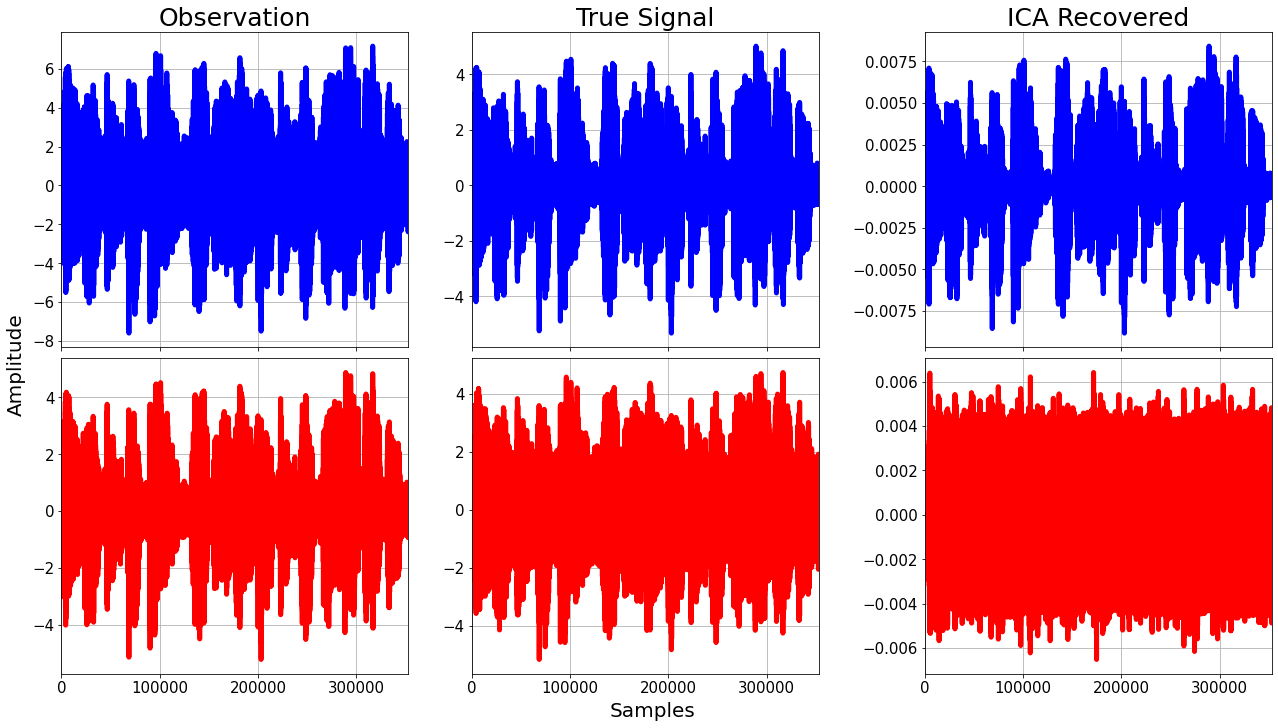

In [171]:
ica(true_signal_1)
# ToDo save fils